# Used libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from math import sqrt

## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [2]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


In [3]:
ret=[f'RET_{k}' for k in range(20,0,-1)]
vol=[f'VOLUME_{k}' for k in range(20,0,-1)]

# Exploration des secteurs

Nombre de points par secteur :

In [4]:
nb_sto = max(len(train.STOCK.unique()),len(test.STOCK.unique()))
nb_sub_ind = max(len(train.SUB_INDUSTRY.unique()),len(test.SUB_INDUSTRY.unique()))
nb_ind = max(len(train.INDUSTRY.unique()),len(test.INDUSTRY.unique()))
nb_grp_ind = max(len(train.INDUSTRY_GROUP.unique()),len(test.INDUSTRY_GROUP.unique()))
nb_sec = max(len(train.SECTOR.unique()),len(test.SECTOR.unique()))
print("Nombre total d'actions :", nb_sto)
print("Nombre total de sub-industries :", nb_sub_ind)
print("Nombre total d'industries :", nb_ind)
print("Nombre total de groupes industriels :", nb_grp_ind)
print("Nombre total de secteurs :", nb_sec)
print(max(test.SUB_INDUSTRY.unique()))
print(max(test.INDUSTRY.unique()))
print(max(test.INDUSTRY_GROUP.unique()))
print(max(test.SECTOR.unique()))


Nombre total d'actions : 5350
Nombre total de sub-industries : 182
Nombre total d'industries : 75
Nombre total de groupes industriels : 27
Nombre total de secteurs : 12
182
74
26
11


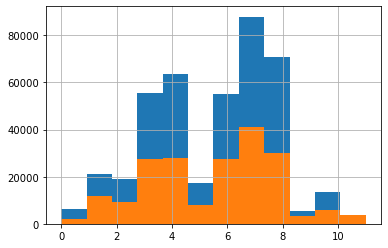

In [5]:
x_train.SECTOR.hist(bins=nb_sec)
test.SECTOR.hist(bins=nb_sec)

In [6]:
train.groupby(by='SECTOR').count()['DATE']
#test.groupby(by='STOCK').count()['DATE']

SECTOR
0      6304
1     21264
2     18967
3     55473
4     63519
5     17295
6     55123
7     87903
8     70843
9      5555
10    13295
11     3054
Name: DATE, dtype: int64

# Cleaning : remplacement des NaN par les médianes par secteur

Remplacement des Na : 

In [7]:
train_cl = train.copy()
test_cl = test.copy()
for indu in range(nb_ind):
    for ret_t,vol_t in zip(ret,vol):
        med_ret_train = train[ret_t][train['INDUSTRY_GROUP']==indu].median()
        med_vol_train = train[vol_t][train['INDUSTRY_GROUP']==indu].median()
        med_ret_test = train[ret_t][train['INDUSTRY_GROUP']==indu].median()
        med_vol_test = train[vol_t][train['INDUSTRY_GROUP']==indu].median()
        
        train_cl[ret_t] = train_cl[ret_t].fillna(med_ret_train)
        train_cl[vol_t] = train_cl[vol_t].fillna(med_vol_train)
        test_cl[ret_t] = test_cl[ret_t].fillna(med_ret_test)
        test_cl[vol_t] = test_cl[vol_t].fillna(med_vol_test)

Suppression Outliers

In [8]:
seuil_ret = 1000;
seuil_vol = 1000;
train_cl  = train_cl [np.all([train_cl[col]<seuil_ret for col in ret],axis=0)]
train_cl  = train_cl [np.all([train_cl[col]<seuil_vol for col in vol],axis=0)]


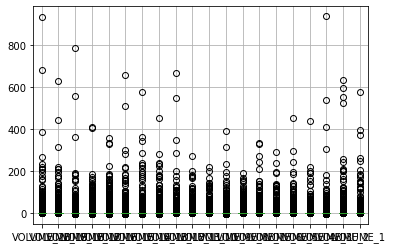

In [9]:
train_cl[vol].boxplot()

# Scaling

In [10]:
scaler = StandardScaler()

In [11]:
train_cl[ret+vol] = scaler.fit_transform(train_cl[ret+vol])
test_cl[ret+vol] = scaler.fit_transform(test_cl[ret+vol])
train_cl.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.548988,0.124742,-0.533127,0.118379,...,0.369547,0.051338,-0.135215,0.244455,0.000154,-0.398164,0.138929,-0.064257,0.044562,True
1,0,3,43,15,6,104,0.083747,-0.085220,-2.963083,-0.069945,...,-0.087656,0.067731,-0.089013,-0.628630,-0.081377,-0.916075,-0.084071,-1.047147,-0.073966,True
2,0,4,57,20,8,142,-0.029884,0.005254,-1.937573,0.079344,...,0.049557,-0.606661,-0.122245,-0.245830,-0.183962,-0.370059,-0.120713,-0.206443,-0.078988,False
3,0,8,1,1,1,2,0.959606,-0.157803,0.219699,0.007117,...,0.060756,1.015335,-0.089066,-0.082767,-0.249017,-0.416536,-0.221487,-1.108184,-0.208420,False
4,0,14,36,12,5,92,0.830524,-0.362132,-1.303373,-0.345607,...,-0.083555,-0.450443,0.132933,0.099901,0.042062,0.165459,0.337076,-1.231085,0.367046,False


In [12]:
test_cl.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
ID,,,,,,,,,,,,,,,,,,,,,
418595,2,0,37,12,5,94,0.659985,0.055211,0.275432,0.054565,...,0.663303,-0.031916,-0.077006,-0.079964,0.023467,0.050283,0.008503,-0.006802,0.644021,0.027280
418596,2,1,15,4,3,37,0.290723,-0.028828,0.664285,-0.097103,...,-0.154947,-0.149778,-0.093803,-0.077944,0.080711,0.194547,-0.236004,-0.080440,0.159131,-0.095930
418597,2,4,57,20,8,142,0.153153,-0.000143,0.139440,0.000810,...,0.063471,-0.078750,0.336667,-0.112172,0.350132,-0.080709,0.013170,0.043524,0.038106,-0.016210
418598,2,5,35,12,5,91,0.498682,0.005255,-0.505231,0.026038,...,-0.453828,0.049484,1.180694,0.209310,-0.076162,0.103012,-0.245979,-0.009691,0.267310,-0.047895
418599,2,6,57,20,8,142,0.366914,-0.036729,0.693621,-0.024313,...,-0.050853,-0.114292,0.099463,-0.103968,-0.865823,-0.049073,0.353061,0.137099,-0.250134,0.231649


<h1>Sélection des features</h1>

## Sélection du niveau d'arboréscence pour chaque modèle

In [13]:
arbre = ['SECTOR','INDUSTRY_GROUP','INDUSTRY','SUB_INDUSTRY','STOCK'];

def niv_arbre(df, lvl_arb, chemin, nb_min_per_mod):
    
    if (lvl_arb == 4 and df.shape[0]>nb_min_per_mod):
            return([[4,df.shape[0],chemin,chemin]])
    
    elif (df.shape[0]<nb_min_per_mod):
        
        if (lvl_arb == 0):
            return([lvl_arb, df.shape[0], chemin, chemin])
        
        return([lvl_arb, df.shape[0], chemin, chemin[0:len(chemin)-1]])
   
    else :
        res = []
   
        for sub_step in (df[arbre[lvl_arb+1]].unique()):
            sub_df = df[df[arbre[lvl_arb+1]]==sub_step]
            
            if sub_df.shape[0]>nb_min_per_mod:
                res = res + niv_arbre(sub_df,lvl_arb+1, chemin+[sub_step],nb_min_per_mod)
                
            elif (lvl_arb == -1):
                res = res + [[0,sub_df.shape[0],chemin+[sub_step],chemin+[sub_step]]]
                
            else : 
                res = res + [[lvl_arb,sub_df.shape[0],chemin+[sub_step],chemin]]
       
        return(res)

def creer_niv_arbre(df, nb_min_per_mod):
    
    grp_data = niv_arbre(df, -1, [], nb_min_per_mod) 
    
    for i in range(12):
        grp_data.append([0,0,0,[i]])
        
    models = np.unique(np.asarray(grp_data)[:,3])
    
    new_model = []
    for i in range(5,-1,-1):  
        for model in models:
            div = len(model)-1
            if i == div:
                new_model.append([div,model[div]])
    models = new_model
    
    
    return(grp_data,models)

grp_data, loc_mods = creer_niv_arbre(train,20000)

print('Nous allons creer', len(loc_mods), 'modèles afin de couvrir les', len(grp_data), 'groupes de données détectés.')


#Vérifiction : 

#count = 0
#for i in arbre:
#    count += i[1]
#print(count,train.shape[0])

Nous allons creer 21 modèles afin de couvrir les 436 groupes de données détectés.


In [14]:
#def niv_arbre(df,nb_min_per_mod):
 #   models = []
  #  
   # for niv in range(4,-1,-1):
    #    for sub_div in df[arbre[niv]].unique():
     #       if sub_div.shape[0]>
        

## Features de base

In [15]:
nb_feat = 20 #nb de jours pris en compte
features_base = ret[-nb_feat:]+vol[-nb_feat:]
target = 'RET'

In [16]:
print(len(grp_data),len(loc_mods))
print(loc_mods)
#print(grp_data)
loc_mods[0]

436 21
[[3, 108], [2, 46], [1, 1], [1, 3], [1, 14], [1, 15], [1, 16], [1, 20], [1, 21], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11]]


[3, 108]

## New features

In [17]:
nb_shifts = 5 #nombre de features supplémentaires
shifts = range(1,nb_shifts+1)

new_features = []

statistics = ['median']
target_feature = 'RET'

for shift in range(1,nb_shifts+1):
    print(shift)
    for stat in statistics:
            
        feat = f'{target_feature}_{shift}'
        name = f'{target_feature}_{shift}_SUBDIVISION_{stat}'
        new_features.append(name)
        
        train_new = pd.Series()
        test_new = pd.Series()
        
        grille_train = pd.Series(index=range(0,418596))
        grille_test = pd.Series(index=range(418595,617024))
       

        for n in range(len(loc_mods)):    
            
            grp = loc_mods[n]
            niv = grp[0]
           
            if niv == 5:
                gb_features = ['STOCK', 'DATE']
            else:
                gb_features = [arbre[niv], 'DATE']
             
            
            #print(data[data[arbre[niv]]==grp[1]].shape[0])
            #print(data[data[arbre[niv]]==grp[1]].groupby(gb_features)[feat].transform(stat).shape[0])
                
            train_set_sub = train_cl[train_cl[arbre[niv]]==grp[1]]
            test_set_sub = test_cl[test_cl[arbre[niv]]==grp[1]]
            
            train_set_sub = train_set_sub[grille_train.isna()]
            test_set_sub = test_set_sub[grille_test.isna()]
            
            train_index = train_set_sub.index
            test_index = test_set_sub.index
            
            grille_train[train_index] = 1
            grille_test[test_index] = 1
                
            train_new_sub = pd.Series(train_set_sub.groupby(gb_features)[feat].transform(stat),index=train_index)
            test_new_sub = pd.Series(test_set_sub.groupby(gb_features)[feat].transform(stat),index=test_index)
                
            train_new = pd.concat([train_new,train_new_sub])
            test_new = pd.concat([test_new,test_new_sub])
            
            #print(grp)
            #print(train_cl[train_cl['INDUSTRY']==12].RET_1_SUBDIVISION_median.head(1))
            
        train_cl[name] = train_new
        test_cl[name] = test_new

1


<ipython-input-17-c862bac52098>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_new = pd.Series()
<ipython-input-17-c862bac52098>:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_new = pd.Series()
<ipython-input-17-c862bac52098>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  grille_train = pd.Series(index=range(0,418596))
<ipython-input-17-c862bac52098>:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  grille_test = pd.Series(index=range(418595,617024))
<ipython-input-17-c862bac52098>:41: U

2
3
4
5


In [18]:
features = features_base + new_features
train_cl.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_19,VOLUME_19,RET_20,VOLUME_20,RET,RET_1_SUBDIVISION_median,RET_2_SUBDIVISION_median,RET_3_SUBDIVISION_median,RET_4_SUBDIVISION_median,RET_5_SUBDIVISION_median
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.548988,0.124742,-0.533127,0.118379,...,-0.398164,0.138929,-0.064257,0.044562,True,0.260528,-0.813371,-0.068625,0.003163,0.160575
1,0,3,43,15,6,104,0.083747,-0.085220,-2.963083,-0.069945,...,-0.916075,-0.084071,-1.047147,-0.073966,True,0.116036,-0.978885,-0.433681,-0.257446,0.126326
2,0,4,57,20,8,142,-0.029884,0.005254,-1.937573,0.079344,...,-0.370059,-0.120713,-0.206443,-0.078988,False,0.266015,-1.250677,-0.426035,-0.033426,0.515045
3,0,8,1,1,1,2,0.959606,-0.157803,0.219699,0.007117,...,-0.416536,-0.221487,-1.108184,-0.208420,False,0.464528,-0.039569,-0.421046,-0.306552,-0.359338
4,0,14,36,12,5,92,0.830524,-0.362132,-1.303373,-0.345607,...,0.165459,0.337076,-1.231085,0.367046,False,0.144626,-0.435881,-0.218921,0.021902,-0.031971


# Entraînement des modèles

In [19]:
models = []
arbre_minuscule = ["du secteur","du groupe industriel","de l'industrie","de la sous-industrie","de l'action"]
print(len(loc_mods), 'modèles à créer')
for n in range(len(loc_mods)):
    loc_mod = loc_mods[n]
    niv = loc_mod[0]
    sub = loc_mod[1]
    
    x_train_cl = train_cl[features][train_cl[arbre[niv]]==sub]
    y_train_cl = train_cl[target][train_cl[arbre[niv]]==sub]
    print("Modèle", n,": calculé sur les données",arbre_minuscule[niv],sub,".",x_train_cl.shape[0],"données.")
     
    rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
    }
    
    model = RandomForestClassifier(**rf_params)
    model.fit(x_train_cl, y_train_cl)
    models.append([model,[niv,sub]])

21 modèles à créer
Modèle 0 : calculé sur les données de la sous-industrie 108 . 29567 données.
Modèle 1 : calculé sur les données de l'industrie 46 . 30325 données.
Modèle 2 : calculé sur les données du groupe industriel 1 . 21264 données.
Modèle 3 : calculé sur les données du groupe industriel 3 . 34588 données.
Modèle 4 : calculé sur les données du groupe industriel 14 . 26249 données.
Modèle 5 : calculé sur les données du groupe industriel 15 . 28873 données.
Modèle 6 : calculé sur les données du groupe industriel 16 . 39290 données.
Modèle 7 : calculé sur les données du groupe industriel 20 . 32650 données.
Modèle 8 : calculé sur les données du groupe industriel 21 . 24179 données.
Modèle 9 : calculé sur les données du secteur 0 . 6304 données.
Modèle 10 : calculé sur les données du secteur 1 . 21264 données.
Modèle 11 : calculé sur les données du secteur 2 . 18967 données.
Modèle 12 : calculé sur les données du secteur 3 . 55473 données.
Modèle 13 : calculé sur les données du sec

In [20]:
models_backup = models
#models

# Prédictions et précision locales

In [21]:
y_pred = pd.Series()
y_test= pd.Series(index=range(0,418596))


nb_ligne = 0;
for n in range(len(models)):
    model = models[n][0]
    
    print("Groupe : ", n)

    div = arbre[models[n][1][0]]  
    sub = models[n][1][1] 
               
    x_test = train_cl[train_cl[div]==sub].loc[:,features]
    x_test = x_test[y_test.isna()]
    
    if (x_test.shape[0] > 0):
        
        index = x_test.index
        y_test[index]=1
    
        y_new = pd.Series(model.predict(x_test),index=index)
        y_pred = pd.concat([y_pred,y_new])
    
y_pred = y_pred.sort_index()


<ipython-input-21-7521f1c00282>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series()
<ipython-input-21-7521f1c00282>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_test= pd.Series(index=range(0,418596))
<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  0
Groupe :  1
Groupe :  2


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]
<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  3


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  4


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  5


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  6


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  7


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  8


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  9
Groupe :  10
Groupe :  11


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]
<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  12


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  13


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  14


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  15
Groupe :  16


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  17


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  18
Groupe :  19


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]
<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  20


<ipython-input-21-7521f1c00282>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


In [22]:
accuracy_score(train_cl[target], y_pred)

0.6900743918928604

# Prédictions sur test set

In [23]:
y_pred = pd.Series()
y_test= pd.Series(index=range(418595,617024))

ligne_count = 0;

for n in range(len(models)):
    model = models[n][0]
    
    print("Groupe : ", n)

    div = arbre[models[n][1][0]]  
    sub = models[n][1][1] 
               
    x_test = test_cl[test_cl[div]==sub].loc[:,features]
    x_test = x_test[y_test.isna()]
    
    if (x_test.shape[0] > 0):
        ligne_count+=x_test.shape[0]
        index = x_test.index
        y_test[index]=1
        
        y_new = pd.Series(model.predict(x_test),index=index)
        y_pred = pd.concat([y_pred,y_new])
  
y_pred = y_pred.sort_index()

<ipython-input-23-fe97e84099bc>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_pred = pd.Series()
<ipython-input-23-fe97e84099bc>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_test= pd.Series(index=range(418595,617024))
<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  0
Groupe :  1
Groupe :  2


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]
<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  3


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  4


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  5


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  6
Groupe :  7


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]
<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  8
Groupe :  9


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]
<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  10
Groupe :  11
Groupe :  12


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  13


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]
<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  14
Groupe :  15
Groupe :  16


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]
<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  17
Groupe :  18


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]
<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  19


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


Groupe :  20


<ipython-input-23-fe97e84099bc>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_test = x_test[y_test.isna()]


# Submission

In [24]:
y_pred.name = target
y_pred.to_csv('y_test_arbo_10000.csv', index=True, header=True)

In [25]:
train_cl[train_cl['SUB_INDUSTRY']==0].shape[0]

6304

In [26]:
print(-(y_pred.shape[0]-test.shape[0]))
print(y_pred.shape[0],test.shape[0])
print(y_test.isna().shape[0],y_test.shape[0])
test_cl[y_test.isna()].shape[0]


0
198429 198429
198429 198429


0